# Data and Setting

In [134]:
import pandas as pd
from collections import defaultdict
import numpy as np
import random
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from collections import Counter
sns.set_theme(style="whitegrid",font_scale = 2)
sns.set_palette('rocket')

### Network

In this first part we load the dataset. We'll use the `nx.convert_matrix.from_pandas_edgelist` function to build the graph later.

In [7]:
#dataframe for the network 

#names of columns
cols = ['edge_ID','source','target']

#loading Dataframe
df_edges = pd.read_csv('wikigraph_reduced.csv', delimiter = '\t',names = cols).drop(index = 0)

#making edge_ID as int
df_edges['edge_ID'] = list(map(int, df_edges['edge_ID']))

#set of all the nodes in the graph
nodes=set(df_edges["source"]).union(set(df_edges["target"]))

In [8]:
df_edges

,edge_ID,source,target
1,796,95,1185516
2,909,108,1059989
3,910,108,1062426
4,911,108,1161925
5,1141,134,541222
...,...,...,...
483090,28511768,1791481,1060990
483091,28511769,1791481,1061382
483092,28511771,1791481,1110380
483093,28511772,1791482,80740


### Page Names

In this subsection we load the dataset containing the names of the nodes.

Since there is not a unique delimiter that separates the node number from the name and using the *\" "* character doesn't work because it would also separates some names (e.g: *\"0 Chiasmal syndrome"* would be split into three parts) we loaded everything into a simple column and then separated the node number from the rest.

In [9]:
df_names = pd.read_csv('wiki-topcats-page-names.txt.gz',names =['node name'])

In [10]:
df_names.head(3)

,node name
0,0 Chiasmal syndrome
1,1 Kleroterion
2,2 Pinakion


In [11]:
df_names['node'] = [s.split()[0] for s in list(df_names['node name']) ]
df_names['name'] = [' '.join(s.split()[1:]) for s in list(df_names['node name'])]
df_names = df_names.drop('node name',axis = 1)

### Categories

In this subsection we load the dataset containing the categories of the nodes. We removed the prefix: *\"Category:"* from each category name and grouped all the pages belonging to a certain category in a list.

In [12]:
names = ['cat_name','pages']
df_cat = pd.read_csv('wiki-topcats-categories.txt.gz',sep = ';',names = names)

df_cat['cat_name'] = df_cat.apply(lambda x: x['cat_name'][9:],axis = 1)

df_cat['pages'] = df_cat.apply(lambda x: list(map(int,x['pages'].split())),axis = 1)

df_cat['lengths'] = df_cat.apply(lambda x : len(x['pages']),axis = 1)

df_cat = df_cat.loc[(df_cat['lengths']>5000) & (df_cat['lengths']<30000)] #removing all the categories whose #pages are not in range (5000,30000)

df_cat

,cat_name,pages,lengths
868,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295...",9237
869,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280...",9467
876,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269...",6959
900,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268...",8270
949,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269...",6668
2791,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,...",6154
4160,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,...",6580
5619,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306...",6546
6067,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233...",5913
6795,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,...",7851


In [13]:
#set of all nodes in df_cat 
nodes_reduced_df_cat = set(df_cat['pages'].sum())

#check if all the nodes in the original database are a subset of the reduced category one
nodes.issubset(nodes_reduced_df_cat)


True

In [14]:
#in order to remove the pages belonging to multiple categories, we made an inverted index key: Page, values: Categories in which the pages appears.
#than I randomly sampled the values in uniform way and built the dataframe again

categories = list(df_cat['cat_name'])
pages_for_cat =list(df_cat['pages'])


d_page_cat = defaultdict(list)
for i,cat in enumerate(categories):
    for pag in pages_for_cat[i]:
        d_page_cat[pag].append(cat)
    



In order to remove the pages belonging to multiple categories we first created an inverted index with <code>key:Page</code>, <code>value:Categories in which the page appears</code>.

Then, for each page we randomly sampled among the values in uniform way to only consider one category. Then we built the dataframe again. 

In [15]:
random.seed(1234)

categories = list(df_cat['cat_name'])
pages_for_cat =list(df_cat['pages'])


d_page_cat = defaultdict(list)
for i,cat in enumerate(categories):
    for pag in pages_for_cat[i]:
        d_page_cat[pag].append(cat)
    
d_random_cat_page = defaultdict(list)

for page in d_page_cat.keys():
    if page in nodes:
        cat_of_page = random.sample(set(d_page_cat[page]),1)
        d_random_cat_page[cat_of_page[0]].append(page)

new_df_cat = pd.DataFrame()
new_df_cat['cat_name'] = d_random_cat_page.keys()
new_df_cat['pages'] = list(d_random_cat_page.values())
#new_df_cat['lengths'] = new_df_cat.apply(lambda x : len(x['pages']),axis = 1)
new_df_cat

,cat_name,pages
0,English_footballers,"[28961, 48718, 72482, 72496, 72545, 72546, 725..."
1,The_Football_League_players,"[33973, 48730, 72488, 72528, 72532, 72536, 725..."
2,Association_football_defenders,"[48583, 72797, 72798, 72820, 72943, 74988, 751..."
3,Year_of_death_missing,"[72579, 72769, 72826, 72852, 72861, 72862, 731..."
4,Association_football_midfielders,"[72605, 73109, 73145, 73310, 74845, 75233, 753..."
5,Association_football_forwards,"[72708, 72802, 72914, 72945, 75360, 75370, 754..."
6,Year_of_birth_missing,"[73047, 75306, 93457, 97876, 107488, 672054, 6..."
7,Place_of_birth_missing_(living_people),"[81209, 82307, 84470, 85728, 83446, 86747, 100..."
8,Members_of_the_United_Kingdom_Parliament_for_E...,"[536703, 536701, 538562, 538800, 539018, 53913..."
9,Harvard_University_alumni,"[1663, 1843, 3260, 3431, 11386, 11858, 12295, ..."


Finally, we built an inverted dictionary with <code>key: node_i</code>,<code>value: category of node_i</code>.

In [16]:
inverted_dictionary={}
for i,row in new_df_cat.iterrows():
    for node in row["pages"]:
        inverted_dictionary[node]=row["cat_name"]
        

# Create Graph

# RQ1
Build the graph $G=(V, E)$, where $V$ is the set of articles and E the hyperlinks among them. Then, provide its basic information:

Is the graph directed?
How many articles are we considering?
How many hyperlinks between pages exist?
Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?
Visualize the nodes' degree distribution

Build the graph $G=(V, E)$, where $V$ is the set of articles and $E$ the hyperlinks among them.

In [17]:
G=nx.convert_matrix.from_pandas_edgelist(df_edges, 'source', 'target', ['edge_ID'],create_using=nx.DiGraph())


### 1. Is the graph directed?

Due the structure of the "headers" in the dataset (source-target) we must assume that the graph is directed. Indeed the object we are trying to model is the hyperlink network of the wikipedia pages and every link is one-sided.

In [18]:
#With this function we can double-check if the function we used effectively created a directed graph.
G.is_directed()

True

### How many articles are we considering?

In our network $G$ the articles are represented by the nodes. Therefore the amount of articles we're considering corresponds to the cardinality of the set of nodes in $G$.

In [19]:
len(G.nodes)

98343

### How many Hyperlinks ?

In $G$ the hyperlinks are represented by the edges. Therefore the amount of Hyperlinks corresponds to the cardinality of the set of edges.

In [20]:
len(G.edges)

483094

It is clear that the graph is really far from being a dense graph: a densely connected graph with 98343 nodes would have 9671247306 edges while this one only has 483094.

In [21]:
graph_density=len(G.edges)/(len(G.nodes)*(len(G.nodes)-1))

In [22]:
graph_density

4.9951571365597335e-05

### Average Degree

We now calculate the average degree of the nodes. Since our graph is directed, we can interpret the question as both asking for the indegree or the outdegree of every node. 

In [23]:
dict_in_degree = dict(G.in_degree())
list_degree_in = list(dict_in_degree.values())
avg_degree_in = np.mean(np.array(list_degree_in))
med_degree_in = np.median(np.array(list_degree_in))
print("Mean of indegree:", avg_degree_in)



Mean of indegree: 4.912337431235573


In [24]:
dict_out_degree = dict(G.out_degree())
list_degree_out = list(dict_out_degree.values())
avg_degree_out = np.mean(np.array(list_degree_out))
med_degree_out = np.median(np.array(list_degree_out))
print("Mean of outdegree:", avg_degree_out)



Mean of outdegree: 4.912337431235573


The fact that these numbers are the same is not surprising: every edge has a target and a source. Since the sum over the nodes of their indegree is equal to the number of edges of the graph and the same as well as for the sum of the outdegree. Hence the average indegree and outdegree have the same value equal to the ratio between the cardinality of the edges and the nodes that we computed above.

In [25]:
len(G.edges)/len(G.nodes)

4.912337431235573

Text(10650, 4, 'Asteroid belt')

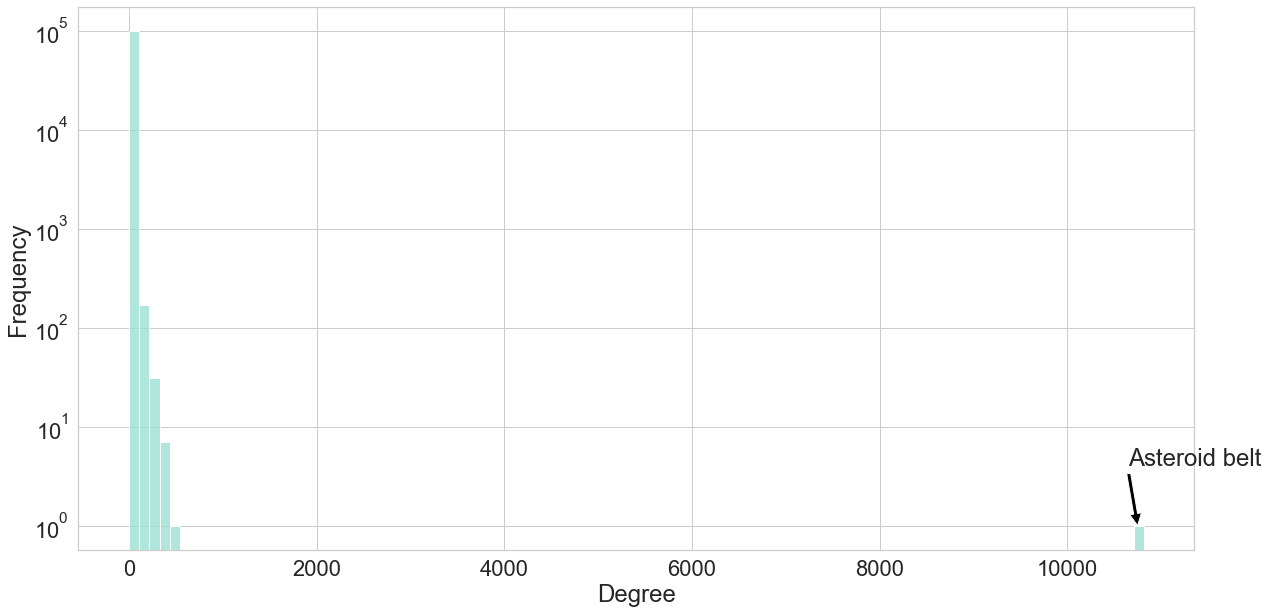

In [179]:
plt.figure(figsize=(20,10))

g = sns.histplot(list_degree_in,bins = 100,color = '#96ded1')

g.set_yscale('log')
g.set_yscale('log')
g.set_xlabel('Degree')
g.set_ylabel('Frequency')


g.annotate('Asteroid belt', xy=(10750.28, 1), xytext=(10650, 4),
            arrowprops=dict(facecolor='black'))


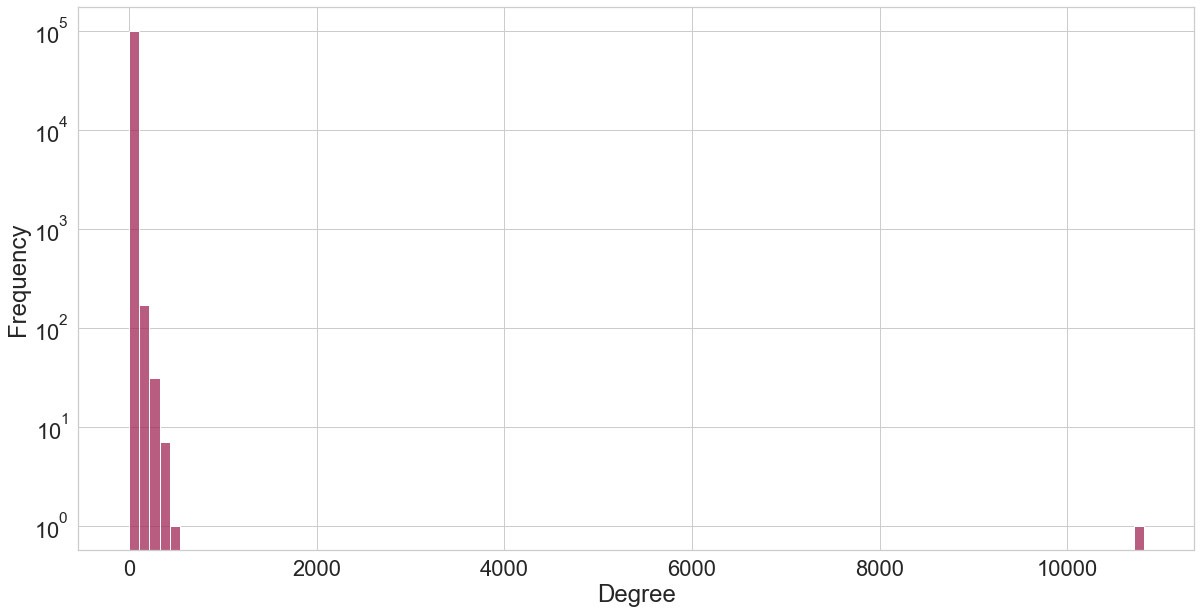

In [177]:
plt.figure(figsize=(20,10))

g = sns.histplot(list_degree_in,bins = 100,color = '#a12655')

g.set_yscale('log')
g.set_yscale('log')
g.set_xlabel('Degree')
g.set_ylabel('Frequency')

g.set_yscale('log')


We found a Node whom out-degree is several order of magnitude higher than the others, and one node that has the same property for the in-degree. We discovered that its the same node, associated to the page <code>Asteroid belt</code>

In [155]:
max(Counter(list_degree_out).items(),key = lambda x: x[0])[1]

1

In [169]:
max(dict_in_degree.items(),key = lambda x: x[1])[0]
df_names.loc[df_names['node']== str(hub)]

,node,name
870589,870589,Asteroid belt


In [170]:
max(dict_out_degree.items(),key = lambda x: x[1])[0]
df_names.loc[df_names['node']== str(hub)]

,node,name
870589,870589,Asteroid belt


# RQ2

Define a function that takes in input a page $v$ and a number of clicks $d$ and returns the set of all pages that a user can reach within $d$ clicks.

In [ ]:
#We use a standard iterative BFS with a queue to avoid having too many recursive calls

def BFS_distances(G,v,n_clicks=float("inf")):

    """G: graph
    v: starting node
    n_clicks: optional parameter. Returns all pages with distance less or equal han n_clicks. Base value is 'float("Inf"):
    it returns every page reached by the BFS."""
    
    
    
    
    
    q = deque() # initialize empty queue
    discovered={} # dictionary with already discovered nodes. The structure is key:Node, value=distance from source
    
    
    discovered[v] = 0 # distance of the source from the source is 0 
    q.append(v)   # put starting vertex in the queue
    
    edges_with_distances=[] #list of tuples (node,distance from source) that will be returned.
    
    while q: #While the queue is not empty, do an iteration of BFS
        v = q.popleft()     #remove first item in the queue
        if discovered[v]>n_clicks:
            break
        edges_with_distances.append((v,discovered[v]))
        
        
 
        for u in G.neighbors(v):
        # for each neighbor u of v. we check if u has already been discovered. If not, we know that its distance of u from the
        # source is one more than the distance v has. 
            
            if u not in discovered: 
                # mark it as discovered and push it into queue
                discovered[u] = discovered[v]+1
                q.append(u)
                
    return edges_with_distances
    

In [ ]:
BFS_distances(G,67030,4)

# RQ3

Define a function that takes in input: a category $C$ and aset of pages in $C$, $p = {p_1, ..., p_n}$
and returns the minimum number of clicks required to reach all pages in $p$, starting from the page $v$, corresponding to the most central article, according to the in-degree centrality, in $C$.

We first add the "Category" as an attribute to every node.

In [ ]:
nx.set_node_attributes(G, inverted_dictionary, name="Category")

We chose to use the in_degree as our metric for the "most central article".

In [ ]:
def most_central_article(G,category):
    
    """ G: graph
        category: one of the categories
        
        returns the node with the highest in_degree as a tuple: (node, in_degree)"""
    
    nodes = list(map(int, d_random_cat_page[category] ))
    assert len(nodes)>0, "Empty/non-existent category!"
    max_in_degree = list(G.in_degree(nodes))
    return max( max_in_degree, key=lambda x:x[1])

In [ ]:
most_central_article(G,'Debut_albums')

The algorithm we will use to solve this problem will have two steps:
First step: we use the function <code>graph_exploration</code> to build a new graph that only has the nodes in the list $p$
and the most central article in the graph. An edge from $u$ to $v$ is added whenever there exists a path from these two nodes in the original graph and the weight of this edge will be equal to the lenght of the shortest path between the two.

Second part: we look for the shortest path that visits all nodes in the new graph that we build in the first step. This is an asymmetric travelling salesman problem (with a slight modification: one does not need to get back to the starting point) with distances satisfying the triangle inequality. We decide to use a slight modification of the "nearest neighbor" algorithm to give an approximation of the solution in a polynomial time: that algorithm can easily answer "no existing path" when there are nodes that are not connected to all the others. Since in our case we know that if $u$ is connected to $v$ and $v$ is connected to $w$ then $u$ is also connected to $w$ (this can be seen as a consequence of the fact that the triangle inequality has to hold and by putting $dist(A,B)=+\infty$ when a directed edge from $A$ to $B$ does not exist). With this property in mind, we know that if we do not see all the unvisited edges in the neighbors of a particular node, than picking that node will lead to a path that doesn't visit all the pages. We try to avoid this by first looking if there is a node that has all the remaining nodes to visit among its neighbors.


(N.B It is interesting to observe how this the "shortest path between two nodes" does not define a distance in the classical sense since it's not symmetric in a generic directed graph with weights)


In [ ]:
def graph_exploration(G,p,C):
    """G: graph
     p: list of nodes  to visit
     C: category where the most central article will be selected as a starting point."""
    
    most_central=most_central_article(G,C)[0] #we compute the most central node
    
    if most_central not in p: #this is here in case one already had the most central node in p
        p.append(most_central) 
    
    new_graph=nx.empty_graph(create_using=nx.DiGraph()) #this creates a new empty graph
    
    for node1 in p:
        for node2 in p:
            if node1!=node2:
                distances=dict(BFS_distances(G,node1)) #we calculate the distances of all the nodes in the graph G from node1
                if node2 in distances: #if node 2 was reached by a BFS from node1, we add an edge in the new graph.
                    new_graph.add_edge(node1,node2,weight=distances[node2])
    new_graph.add_nodes_from(p) #We finally add all the nodes from p, in case there was at least one node that was not
                                #connected to any other in the list
    return new_graph

In [ ]:
p=[1184017,903941,1056184] #The assignment asks for these to be picked in the C category. Our algorithm does not require it,
                           #but it can be done
C='English_footballers'

In [ ]:
new_graph=graph_exploration(G,p,C) #this is the execution of step 1 of the algorithm

In [ ]:
nx.get_edge_attributes(new_graph,"weight") #checking the edges in the newly created graph with their associated weights.

In [ ]:
#This is a slightly modified version of the greedy nearest neighbor algorithm.

def TSP(new_graph,start_node=most_central_article(G,C)[0]):
    
    remaining_nodes=set(new_graph.nodes()) #nodes still not visited
    path=[start_node] #path starts from the startnode
    remaining_nodes.remove(start_node) #we remove the startnode since it has already been visited
    
    current_node=start_node
    
    while (current_node!=None):  #We loop until we cannot find new nodes
        successors=sorted(new_graph.out_edges(current_node,data=True),key=lambda x:x[2]["weight"]) #we sort the neighbors
        #of the current node by weight
        
        current_node=None  #since the current node has already been visited, we set it to "None" and start looking for the next one.
        
        for element in successors: #the successors are ranked by
            node=element[1]
            if remaining_nodes.difference(set(new_graph.successors(node)))==set([node]):
                current_node=node
                path.append(node)
                remaining_nodes.remove(node)
                break
    if remaining_nodes:
        print("Cammino non trovato")
        return None
    edges_of_path=[(path[i],path[i+1],"weight: "+str(nx.get_edge_attributes(new_graph,"weight")[(path[i],path[i+1])])) for i in range(len(path)-1)]
    weights=sum(nx.get_edge_attributes(new_graph,"weight")[edge[:2]] for edge in edges_of_path)
    print("The total lenght of the minimum path is: ",weights)
    print(edges_of_path)       
        
        
    
    
    

In [ ]:
TSP(new_graph)

## RQ4

In [ ]:
def mincut(G, S, T):
    
    #This is a simpler variant of the maxflow problem.
    #We initialize the max_flow to 0 and assume a path exists
    
    max_flow=0
    a_path_exists=True
    already_used_edges=set()
        
    while a_path_exists: #While a path exists, a BFS starts
        predecessor={}
        predecessor[S] = S
        discovered=predecessor.keys()
        # we need to do a BFS from S looking for T. We cannot use edges already used in previus searches.
        
        q = deque()
        
        q.append(S) #We push S into the queue to start the BFS
        while q: #While the queue is not empty
            v = q.popleft()
            for u in G.neighbors(v):
                if (u not in discovered) and ((v,u) not in already_used_edges):
                    # mark it discovered and push it into queue
                    predecessor[u] = v #warning: this also modifies the discovered array!
                    q.append(u)
                    if (T in discovered):
                        max_flow+=1
                        node=T
                        while predecessor[node]!=node:
                            already_used_edges.add((predecessor[node],node))
                            node=predecessor[node]
                        q=[]
                        break
                        
        if (T not in discovered):
            a_path_exists=False
    return (max_flow)

In [ ]:
mincut(G,1059989 ,1161925)

# RQ5

In [ ]:
def BFS_distances(G,v,inf_distances=True,p=None):
    "we use a standard iterative BFS with a queue to avoid having too many recursive calls"
    inf=float("inf")
    
    q = deque()
    discovered={}
    discovered[v] = 0
    # put starting vertex in the queue
    q.append(v)
    edges_with_distances=[]
    vertices=G.nodes
    while q:
        v = q.popleft()
        
        edges_with_distances.append((v,discovered[v]))
 
        for u in G.neighbors(v):
            if u not in discovered:
                # mark it discovered and push it into queue
                discovered[u] = discovered[v]+1
                q.append(u)
    return edges_with_distances
    

In [ ]:
Category1='Association_football_defenders'
Category2='American_television_actors'
Category_test='Place_of_birth_missing_(living_people)'

In [ ]:
nodes=list(map(int,d_random_cat_page[Category1]))
all_distances={}
for v in tqdm(nodes):
    distances=BFS_distances(G,v)
    all_distances[v]=dict(distances)

In [ ]:
counter=0
medians=[]

for i in tqdm(d_random_cat_page):
    counter+=1
    temp_nodes=list(map(int,d_random_cat_page[i]))
    distances=[]
    
    
    for c_0 in nodes:
        for c_i in temp_nodes:
            try:
                distances.append(all_distances[c_0][c_i])
            except KeyError:
                distances.append(float("inf"))
    
    medians.append((i,np.median(np.array(distances))))
    #print("The distance between", Category1, "and", i,"is", np.median(np.array(distances)),"    Counter= ",counter,"/",len(d_random_cat_page))


In [ ]:
medians=sorted(medians,key=lambda x:x[1])

In [ ]:
medians[:10]

## RQ 6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.


#### Building the DataFrame
In order to accomplish this task, we built a graph in the following way:
* each node represent a category
* the node associated to the category_1 points the node of the category_2 if there is at least one page in category_1 that points a page in category_2

In order to build this network we replaced all the pages in the dataframe <code>edges</code> with their respective categories, by mean of <code>cat_of_page</code> dictionary, which returns for every page, the category to which it belongs.
Then we converted the dataframe into a Graph Object with the same procedure applied above.

#### The Page Rank Score
First we modify a little the network, adding a link to every other node from the nodes whose out-degree is zero. 

Then we build the network's matrix $p$ ,  $p_{ij}=  d * \frac{1}{|N|} + (1-d)* 1_{\{(i,j)\}}*\frac{1}{\delta^+(n_i)}$. 
Where:
* $N$ = Set of the nodes
* $d$ = *dumping factor*, probability that the web-surfer goes to the next category through the search bar (instead of using a link of the page). Default = 0.85.
* $1_{\{(i,j)\}} = 1$ if $\exists$ edge $(i,j)$  , $0$ else
* $\delta^+(n_i)$ is the *out-degree* of the node 

The Page Rank vector is an enginevector of enginevalue 1 of $p$. Therefore, if we start from a random page (e.g. the first one) $q_0$, and then we iterate $q_{(t+1)} = p* q_{(t)}$, eventually we will converge to it after a finite number of steps.


In [36]:
#Building the Data Frame of Categories
cat_of_page = {}

for cat in d_random_cat_page: #d_random_cat_page returns for each category, the list of the pages belonging to it
    for page in d_random_cat_page[cat]: # in cat_of_pages we assign to each page in
        cat_of_page[page] = cat         # d_random_cat_page[cat], the category as value
                                        
        

In [37]:
df_edges_cat = pd.DataFrame()
df_edges_cat['source'] = [cat_of_page[page] for page in df_edges['source']]
df_edges_cat['target'] = [cat_of_page[page] for page in df_edges['target']]


In [38]:
df_edges_cat #the nodes are replaced with the categories 

,source,target
0,Debut_albums,Place_of_birth_missing_(living_people)
1,Debut_albums,English-language_films
2,Debut_albums,American_film_actors
3,Debut_albums,Place_of_birth_missing_(living_people)
4,American_films,Members_of_the_United_Kingdom_Parliament_for_E...
...,...,...
483089,English-language_films,American_film_actors
483090,English-language_films,American_television_actors
483091,English-language_films,Place_of_birth_missing_(living_people)
483092,The_Football_League_players,English_footballers


In [39]:
G_cat=nx.convert_matrix.from_pandas_edgelist(df_edges_cat, 'source', 'target',create_using=nx.DiGraph())

In [40]:
len(G_cat)

21

In [41]:
import copy

def PageRank(G,alpha=0.85,max_iter=100,epsilon=1e-6):
    d_node = {node: i for i,node in enumerate(list(G.nodes()))}  #map each node with a number
    
    n = len(G.nodes()) 
    
    # p = d*uniform_p + (1-d)* outlink_p
    
    uniform_p = np.full((n,n),1/n)  #uniform_p = matrix  1/n * I , dim(I) = n X n 
    
    outlink_p = np.zeros((n,n))  #outlink_p[i,j] = 1/deg(i) *1_{(i,j) exists}
    for node in G.nodes():
        i = d_node[node]
        for neigh in G.successors(node):
            j = d_node[neigh]
            outlink_p[i][j] = 1/len(list(G.successors(node)))
    
    #adding an edge to each node for those nodes whose out-degree = 0         
    for i in range(n):
        if np.sum(outlink_p[i])==0:
            outlink_p[i] = np.full((1, n), 1/n) 
    
    p = (1-alpha)*uniform_p+(alpha)*outlink_p
    
    q = np.zeros((1,n)) 
    
    q[0][0] = 1  #we start from the first category
    
    def distance(A,B):
        C = np.abs(A-B)
        return np.sum(C)
    
    for i in tqdm(range(max_iter)):
        q_new = np.dot(q,p) #q_(t+1) = q_(t) *p 
        
        if epsilon: #establish a criteria for the convergence, if the q's of two consecutive steps are close -> stop.
            if distance(q,q_new) < epsilon:
                break
        
        q = q_new

    d = {node: q[0][d_node[node]] for node in G.nodes()} #for each category, we indicate the page rank score
    
    return d


Above we report the PageRank score computed by Network

In [101]:
PR_nx_tuples = nx.pagerank(G_cat,alpha = 0.85,max_iter= 100).items()

PR_nx = pd.DataFrame(PR_nx_tuples,columns=['Category','Page Rank']).sort_values(['Page Rank','Category'],ascending = False)

PR_nx 


,Category,Page Rank
2,English-language_films,0.072838
11,Year_of_death_missing,0.053932
1,Place_of_birth_missing_(living_people),0.053932
3,American_film_actors,0.053932
6,American_television_actors,0.053932
5,Members_of_the_United_Kingdom_Parliament_for_E...,0.052056
15,Year_of_birth_missing,0.051427
4,American_films,0.050795
13,Association_football_midfielders,0.050090
14,Association_football_forwards,0.050090


In [100]:
PR_dict  = PageRank(G_cat,epsilon = False)

PR_tuples = PR_dict.items()

PR = pd.DataFrame(PR_tuples,columns=['Category','Page Rank']).sort_values(['Page Rank','Category'],ascending = False)

PR

100%|██████████| 100/100 [00:00<00:00, 61726.33it/s]


,Category,Page Rank
2,English-language_films,0.072836
11,Year_of_death_missing,0.053932
1,Place_of_birth_missing_(living_people),0.053932
6,American_television_actors,0.053932
3,American_film_actors,0.053932
5,Members_of_the_United_Kingdom_Parliament_for_E...,0.052057
15,Year_of_birth_missing,0.051428
4,American_films,0.050795
13,Association_football_midfielders,0.050090
14,Association_football_forwards,0.050090


100%|██████████| 100/100 [00:00<00:00, 56021.16it/s]


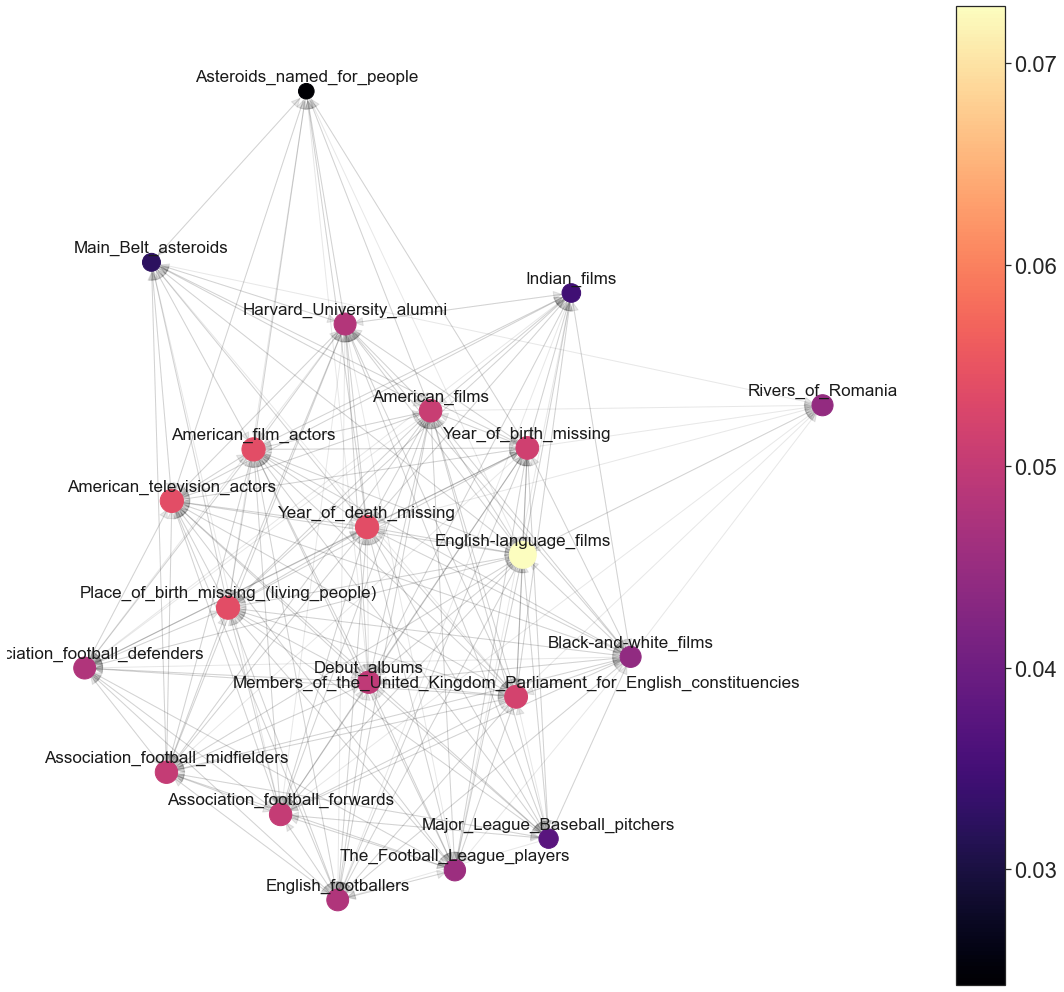

In [115]:
PR_dict  = PageRank(G_cat,epsilon = False)

PR_tuples = PR_dict.items()

PR = pd.DataFrame(PR_tuples,columns=['Category','Page Rank']).sort_values(['Page Rank','Category'],ascending = False)

colors = [PR_dict[n] for n in G_cat.nodes()]
sizes = [PR_dict[n]*10000 for n in G_cat.nodes()]
plt.figure(figsize=(20,18))


# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.kamada_kawai_layout(G_cat)
ec = nx.draw_networkx_edges(G_cat, pos, alpha=0.1,arrowsize=20)
nc = nx.draw_networkx_nodes(G_cat, pos, nodelist=G_cat.nodes(), node_color=colors, 
                            with_labels=True, node_size=sizes, cmap=plt.cm.magma)
pos_higher = {}
y_off = 0.03  # offset on the y axis

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)


lc = nx.draw_networkx_labels(G_cat, pos_higher, font_size=17)

plt.colorbar(nc)
plt.axis('off')
plt.show()


In [73]:
A=nx.condensation(G, scc=None)

In [ ]:
len(A.edges)

In [ ]:
H=nx.empty_graph(create_using=nx.DiGraph())

In [ ]:
H.add_edges_from([(1,2),(2,3),(2,4),(2,5),(2,6)])
for i in range(200):
    H.add_edges_from([(i+1,i)])

In [ ]:
%%time
plt.figure(figsize=(80,80))
nx.draw(nx.condensation(H, scc=None))

In [ ]:
H=A